<a href="https://colab.research.google.com/github/sheha919/Stroke_Prediction/blob/main/stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Information about the dataset

source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

**Attribute Information**

1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

#Import Libraries


In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config(display='diagram')

#Load Data

In [57]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [58]:
#make a copy
ml_df = df.copy()
ml_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#Explore Data

In [59]:
ml_df.shape

(5110, 12)

In [60]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [61]:
#checking for duplicates
ml_df.duplicated().sum()

0

No duplicate data

In [62]:
#checking for missing data
ml_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

'bmi' Column has 201 missing data. I will require to impute using Simple Imputer at the data preprocessing step.

In [63]:
#checking the balance level of data
ml_df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

The data set is unbalanced, need to fix this. 

In [64]:
#checking for inconsistencies in categorical data
data_types = ml_df.dtypes
str_object = data_types[data_types=='object'].index

for i in str_object:
  print(f'Column Name: {i}')
  print(ml_df[i].value_counts())
  print('\n')

Column Name: gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


Column Name: ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64


Column Name: work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Column Name: Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


Column Name: smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64




- Seems like there are no inconsistencies in the categorical data
- In the description of database, it is mentioned that "Unknown" in smoking_status means that the information is unavailable for this patient. Therefore, the 'unknown' values can be considered as missing data.
- All categorical data columns ontain nominal data

In [65]:
#replacing 'unknown' with NAN
ml_df['smoking_status'].replace('Unknown', np.nan, inplace = True)
ml_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [66]:
#rechecking missing data
ml_df.isna().sum()

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64

Now, both 'bmi' and 'smoking_status' have missing data


In [67]:
#checking the inconsistencies in numerical data
ml_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- 'id' column does not provide useful data to the analysis. Therefore, it can be removed.

In [68]:
ml_df.drop(columns = ['id'], axis = 1, inplace = True)
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- Since it is suspicious to have a decimal number as the age, just explore the 'age' column 

In [69]:
#explore the age column
ml_df[ml_df['age']<1]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
363,Female,0.64,0,0,No,children,Urban,83.82,24.9,NaN,0
376,Female,0.88,0,0,No,children,Rural,88.11,15.5,NaN,0
564,Female,0.32,0,0,No,children,Rural,73.71,16.2,NaN,0
982,Male,0.88,0,0,No,children,Rural,157.57,19.2,NaN,0
996,Male,0.24,0,0,No,children,Rural,118.87,16.3,NaN,0
1093,Female,0.32,0,0,No,children,Rural,55.86,16.0,NaN,0
1206,Female,0.72,0,0,No,children,Urban,66.36,23.0,NaN,0
1317,Male,0.80,0,0,No,children,Rural,98.67,17.5,NaN,0
1600,Male,0.40,0,0,No,children,Urban,109.56,14.3,NaN,0
1614,Female,0.08,0,0,No,children,Urban,139.67,14.1,NaN,0


- Seems like all the entries which have less than 1 year as the age are children. Therefore, no need to change anything in 'age column'.

- All other numerical columns look fine too.

# Data Analysis and Visualization

## Univarient Analysis

In [70]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [71]:
data_types = ml_df.dtypes
str_num = data_types[data_types!='object'].index
str_num

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object')

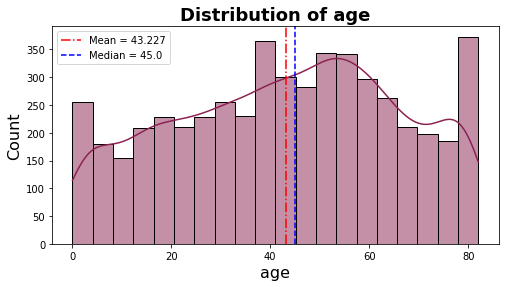

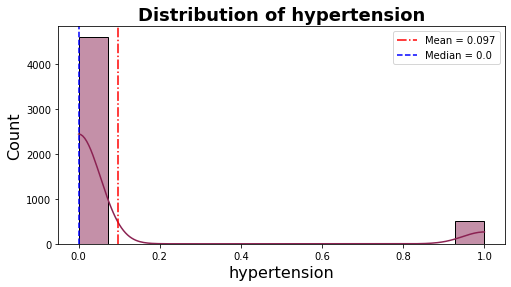

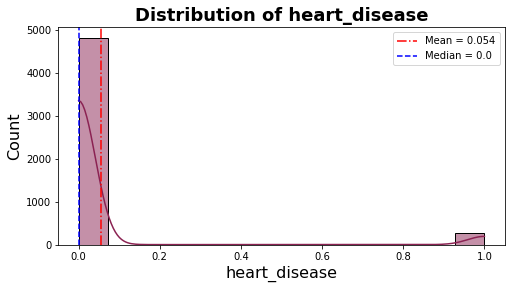

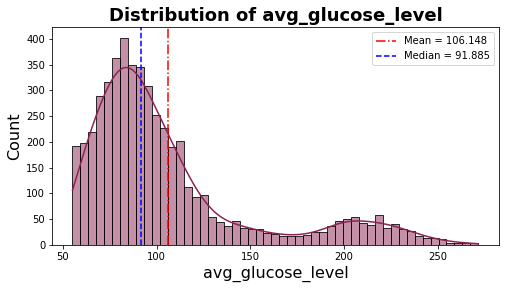

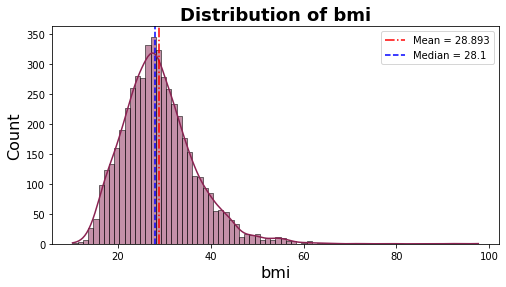

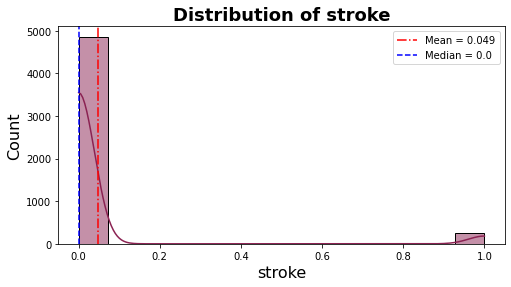

In [72]:
from pyparsing.helpers import line
for i in str_num:
  fig, ax = plt.subplots(figsize= (8,4))
  sns.histplot(data = ml_df, x = i, bins = 'auto', kde=True, color = '#8B2252')
  avg = ml_df[i].mean()
  ax.axvline(avg, ls = '-.', color = 'red', label = f'Mean = {round(avg,3)}')
  median = ml_df[i].median()
  ax.axvline(median, ls = '--', color = 'blue', label = f'Median = {round(median,3)}')
  ax.set_xlabel(i, fontsize = 16)
  ax.set_ylabel('Count', fontsize =16)
  ax.set_title(f'Distribution of {i}', fontsize = 18, fontweight = 'bold')
  ax.legend();



- Above histrogams illustrate the distribution of each feature with its mean and median values.
- According to them, not any of features showing outliers.

#Multivariate Analysis 

In [73]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Text(0.5, 1.0, 'Correlation between features')

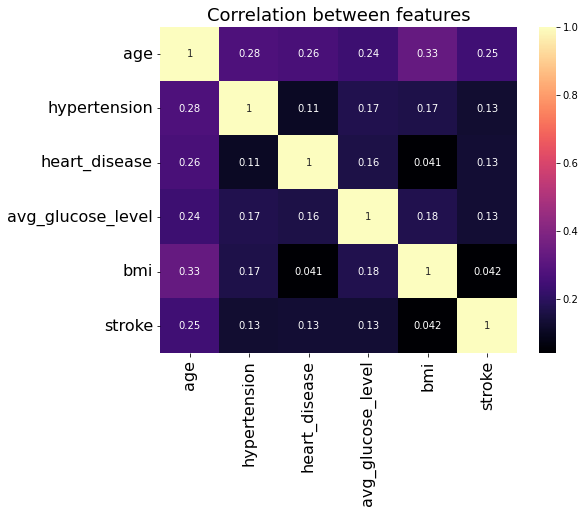

In [74]:
corr = ml_df.corr()
plt.figure(figsize = (8,6))
sns.heatmap(data =corr, annot = True, cmap = 'magma')
plt.xticks(fontsize =16)
plt.yticks(fontsize =16)
plt.title('Correlation between features', fontsize =18)

- The highest correlation shows between age and BMI which is 0.33
- The lowest correlation shows between BMI and having a heart disease or not

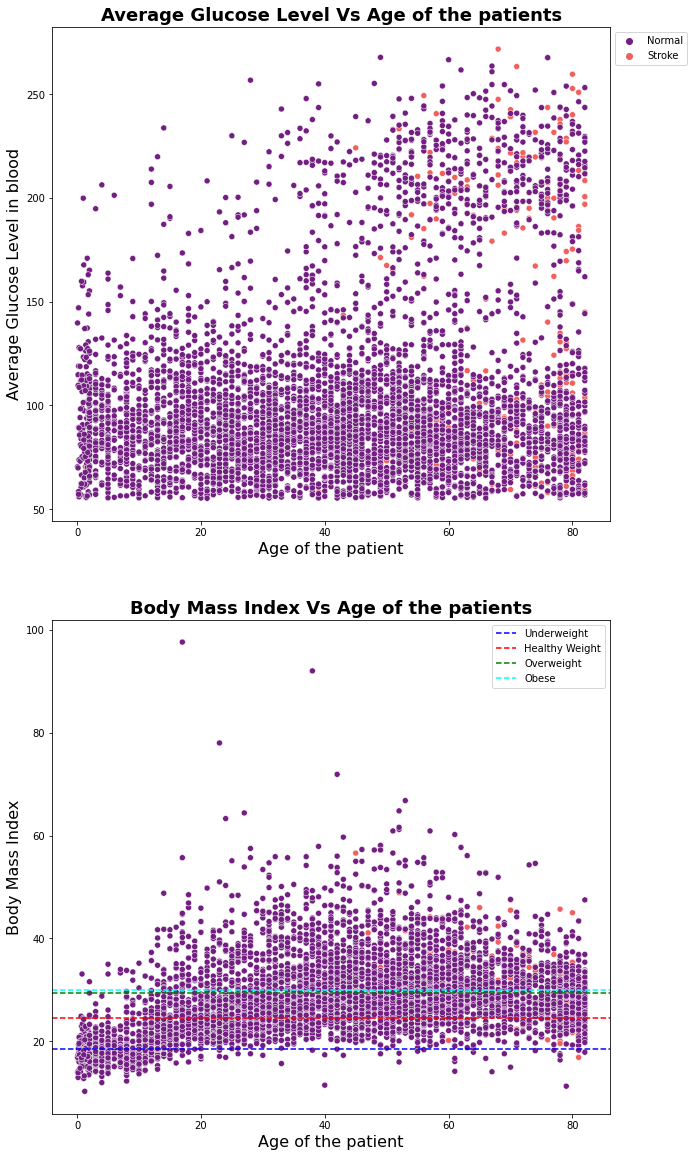

In [75]:
fig, axes = plt.subplots(2,1, figsize = (10,20))
sns.scatterplot(data = ml_df, x = 'age', y = 'avg_glucose_level', hue = 'stroke', palette="magma", ax= axes[0])
legend_labels, _= axes[0].get_legend_handles_labels()
axes[0].legend(legend_labels, ['Normal', 'Stroke'], bbox_to_anchor=(1,1))
axes[0].set_xlabel('Age of the patient', fontsize = 16)
axes[0].set_ylabel('Average Glucose Level in blood', fontsize = 16)
axes[0].set_title('Average Glucose Level Vs Age of the patients', fontsize = 18, fontweight = 'bold')


sns.scatterplot(data = ml_df, x = 'age', y = 'bmi', hue = 'stroke', palette="magma", ax = axes[1], legend= False)
axes[1].set_xlabel('Age of the patient', fontsize = 16)
axes[1].set_ylabel('Body Mass Index', fontsize = 16)
axes[1].set_title('Body Mass Index Vs Age of the patients', fontsize = 18, fontweight = 'bold')
axes[1].axhline(18.5, ls = '--', color = 'blue', label = 'Underweight')
axes[1].axhline(24.5, ls = '--', color = 'red', label = 'Healthy Weight')
axes[1].axhline(29.5, ls = '--', color = 'green', label = 'Overweight')
axes[1].axhline(30, ls = '--', color = 'cyan', label = 'Obese')

axes[1].legend()

- Most of the patients have average glucose level below ~ 140. But the patients with higher than 140 are increasing with as the age increment. 
- Everyone with stroke fall above the age of 40 years.
- Most of patients are below the ~ 50 level of BMI.
- According to the CDC, patients can be catergorized as;
  - BMI is less than 18.5: Underweight range
  - BMI is 18.5 to 24.9: Healthy Weight range
  - BMI is 25.0 to 29.9: Overweight range
  - BMI is 30.0 or higher: Obese range


(source: https://www.cdc.gov/healthyweight/assessing/index.html)


- Most of the underweight patients fall under 20 years
- The majority of patients suffer from obesity are in between 20 and 60 years of age. 

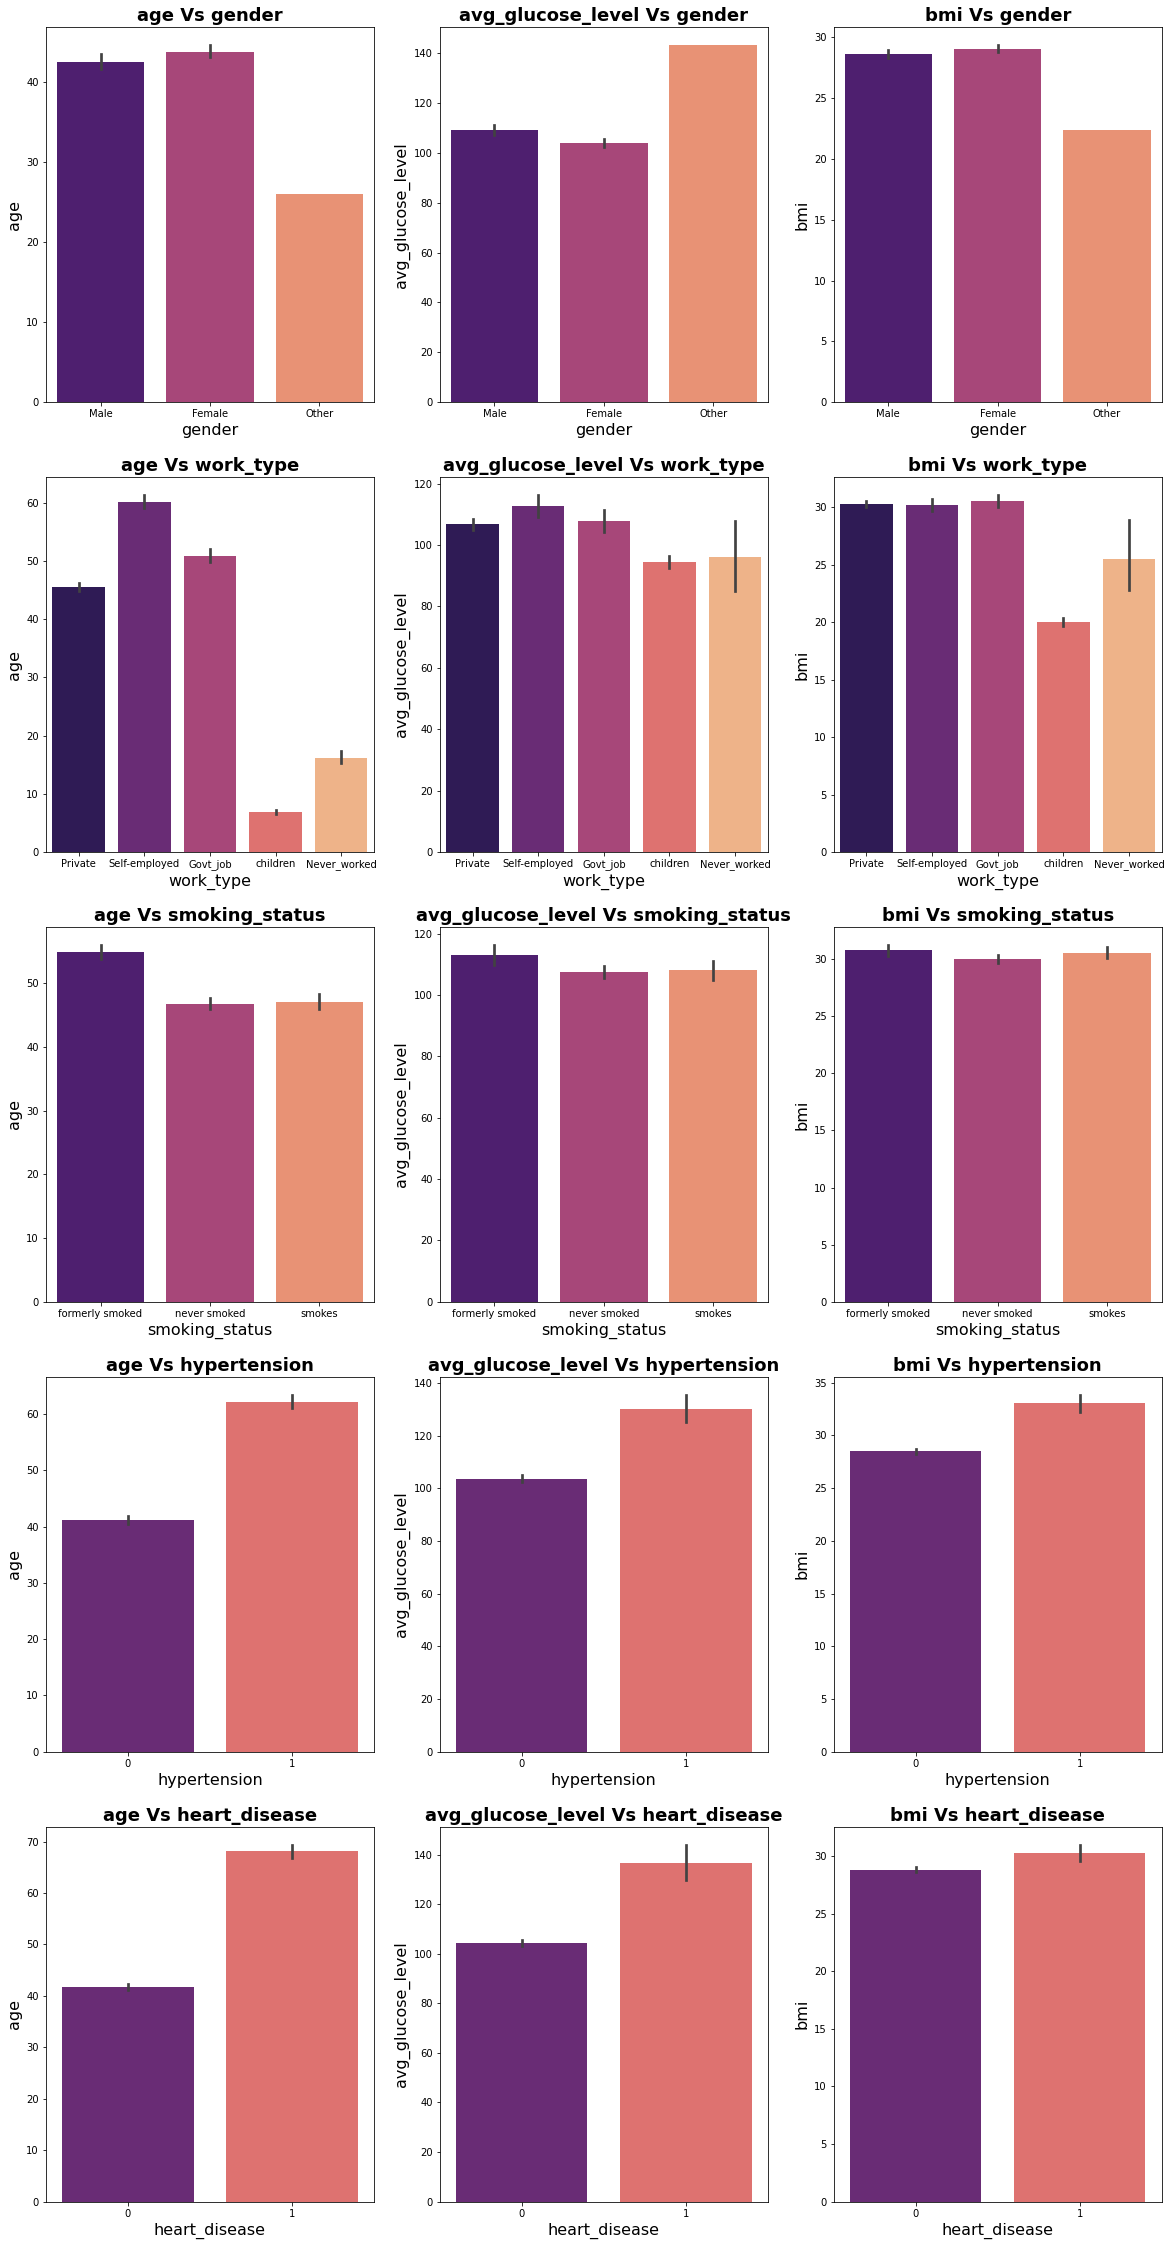

In [83]:
cat_col = ['gender', 'work_type', 'smoking_status', 'hypertension',	'heart_disease']
num_col = ['age', 'avg_glucose_level', 'bmi']

fig, axes = plt.subplots(len(cat_col), len(num_col), figsize = (20,40))
for i, icol in enumerate(cat_col):
  for j, jcol in enumerate(num_col):
    sns.barplot(data = ml_df, x = icol, y = jcol, palette="magma", ax = axes[i,j])
    axes[i,j].set_xlabel(icol, fontsize = 16)
    axes[i,j].set_ylabel(jcol, fontsize = 16)
    axes[i,j].set_title(f'{jcol} Vs {icol}', fontsize = 18, fontweight = 'bold');


According to the above grid of bar charts;
  - Male and female patients have almost similar mean age, glucose levels and BMI
  - For adult patients, the BMI and glucose levels do not depend on the job type. (Never worked patients can be consider as teenagers, thus not catergorized as adults)
  - Seems like average glucose and BMI do not vary on the smoking status much.
  - Patients with hypertension and heart disease are also suffering from obesity and prediabetes or diabates.
  

According to CDC;
  - Diabetes:	above	126 mg/dL 
  - Prediabetes:	100 – 125 mg/dL	
  - Normal: Below 99 mg/dL 
  
(source: https://www.cdc.gov/diabetes/basics/getting-tested.html#:~:text=Fasting%20Blood%20Sugar%20Test&text=A%20fasting%20blood%20sugar%20level,higher%20indicates%20you%20have%20diabetes.)